In [1]:
!kaggle datasets download -d qrsforever/welding-spots-100


Dataset URL: https://www.kaggle.com/datasets/qrsforever/welding-spots-100
License(s): apache-2.0
 50% 5.00M/9.98M [00:00<00:00, 48.1MB/s]
100% 9.98M/9.98M [00:00<00:00, 73.1MB/s]


In [2]:
!unzip welding-spots-100.zip -d welding-spots-100


Archive:  welding-spots-100.zip
  inflating: welding-spots-100/welding_spots/image/001.jpg  
  inflating: welding-spots-100/welding_spots/image/002.jpg  
  inflating: welding-spots-100/welding_spots/image/003.jpg  
  inflating: welding-spots-100/welding_spots/image/004.jpg  
  inflating: welding-spots-100/welding_spots/image/005.jpg  
  inflating: welding-spots-100/welding_spots/image/006.jpg  
  inflating: welding-spots-100/welding_spots/image/007.jpg  
  inflating: welding-spots-100/welding_spots/image/008.jpg  
  inflating: welding-spots-100/welding_spots/image/009.jpg  
  inflating: welding-spots-100/welding_spots/image/010.jpg  
  inflating: welding-spots-100/welding_spots/image/011.jpg  
  inflating: welding-spots-100/welding_spots/image/012.jpg  
  inflating: welding-spots-100/welding_spots/image/013.jpg  
  inflating: welding-spots-100/welding_spots/image/014.jpg  
  inflating: welding-spots-100/welding_spots/image/015.jpg  
  inflating: welding-spots-100/welding_spots/image/01

In [3]:
!ls welding-spots-100


welding_spots


## Import Tools

In [4]:
import requests
import os
import sys

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        sys.stderr.write(f'request {x} : {err}')
        pass

_IMPORT('github.com/qrsforever/nb_easy/easy_show')
_imread = nbeasy_imread
_imshow = nbeasy_imshow
_imgrid = nbeasy_imgrid

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

plt.style.use("dark_background")

## Welding Splot Dataset

In [6]:
dataset_path = '/content/welding-spots-100/welding_spots'
image_path = f'{dataset_path}/image'
mask_path = f'{dataset_path}/mask'
image_size = 256

image_files = os.listdir(image_path)
len(image_files)

100

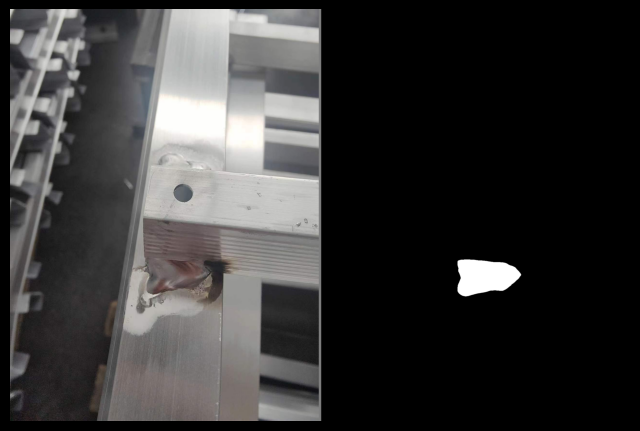

In [7]:
img0 = _imread(f'{image_path}/{image_files[0]}')
msk0 = _imread(f'{mask_path}/{image_files[0].replace("jpg", "png")}')

_imshow(_imgrid([img0, msk0], padding=10, pad_value=127), figsize=(8, 8))

In [11]:
class WeldingSplotsDataset(Dataset):
    def __init__(self, image_path, mask_path, transforms=None, debug=False):
        self.transforms = transforms
        self.debug = debug
        self.imgs, self.msks = [], []
        for file in os.listdir(image_path):
            self.imgs.append(f'{image_path}/{file}')
            self.msks.append(f'{mask_path}/{file.replace("jpg", "png")}')

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.imgs[index]), cv2.COLOR_BGR2RGB)
        msk = cv2.imread(self.msks[index], cv2.IMREAD_GRAYSCALE)
        if self.transforms:
            if not self.debug:
                msk = np.asarray(msk, dtype=np.float32)
                msk = np.expand_dims(msk, 2)
                msk[msk == 255.0] = 1.
            augmented = self.transforms(image=img, mask=msk)
            img = augmented['image']
            msk = augmented['mask']
        return img, msk

transforms_list = [
    A.Resize(height=image_size, width=image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    # A.RandomGamma(p=0.25),
    # A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    # A.OneOf([
    #    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #    A.GridDistortion(p=0.5),
    #    A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    # ], p=0.8),

    #A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    A.Normalize(),
    ToTensorV2(transpose_mask=True),
]

show_transforms = A.Compose(transforms_list[:-3])

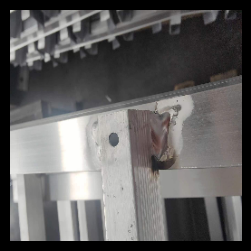

In [12]:
dataset = WeldingSplotsDataset(image_path, mask_path, transforms=show_transforms, debug=True)
samples = iter(dataset)
img, msk = next(samples)
_imshow(img)

(256, 256, 3) (256, 256)


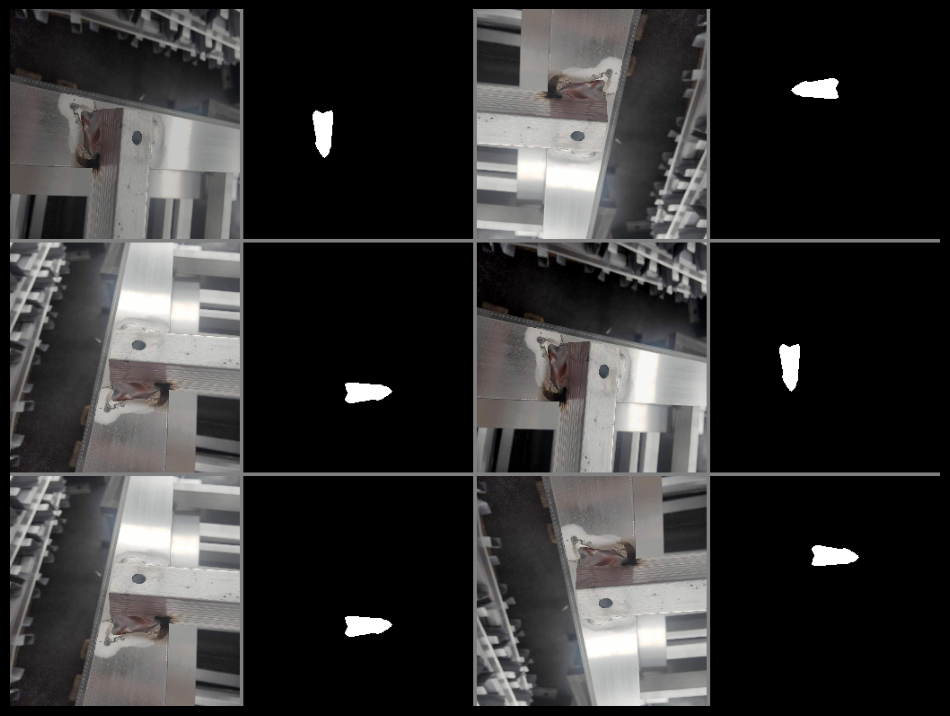

In [13]:
dataset = WeldingSplotsDataset(image_path, mask_path, transforms=show_transforms, debug=True)

pairs = []
for i in range(6):
    samples = iter(dataset)
    img, msk = next(samples)
    pairs.extend([img, msk])

print(img.shape, msk.shape)
_imshow(_imgrid(pairs, nrow=4), figsize=(12, 12))

In [45]:
train_transforms = A.Compose(transforms_list)
train_dataset = WeldingSplotsDataset(image_path, mask_path, transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=8, num_workers=4, shuffle=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [46]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))


class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x


class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)


class UnetFPN(nn.Module):

    def __init__(self, n_classes=1,
                 pyramid_channels=256,
                 segmentation_channels=256):
        super().__init__()

        # Bottom-up layers
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)

        # Top layer (bottleneck)
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)

        # Segmentation block layers
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])

        # Last layer
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)

    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True)

        return upsample(x) + y

    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)

    def forward(self, x):

        # Bottom-up
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4))

        # Top-down
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2))

        # Smooth
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)

        # Segmentation
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]

        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w)

        out = torch.sigmoid(out)
        return out

In [47]:
import os
force_train = False
model_path = '/kaggle/working/UnetFPN_100.pt'
if not force_train and not os.path.exists(model_path):
     !wget https://datasets-1301930378.cos.ap-beijing.myqcloud.com/samples/weldingspots/UnetFPN_100.pt

--2025-02-19 21:58:51--  https://datasets-1301930378.cos.ap-beijing.myqcloud.com/samples/weldingspots/UnetFPN_100.pt
Resolving datasets-1301930378.cos.ap-beijing.myqcloud.com (datasets-1301930378.cos.ap-beijing.myqcloud.com)... 82.156.94.48, 82.156.94.13, 82.156.94.17, ...
Connecting to datasets-1301930378.cos.ap-beijing.myqcloud.com (datasets-1301930378.cos.ap-beijing.myqcloud.com)|82.156.94.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100976543 (96M) [application/octet-stream]
Saving to: ‘UnetFPN_100.pt’

UnetFPN_100.pt      100%[===================>]  96.30M  14.3MB/s    in 8.5s    

2025-02-19 21:59:01 (11.4 MB/s) - ‘UnetFPN_100.pt’ saved [100976543/100976543]



In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UnetFPN().to(device)
output = model(torch.randn(1, 3, image_size, image_size).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


## Train Models

In [50]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]),
                 np.array([0., 1]))

0.9473684210526316

In [51]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]),
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [52]:
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)

In [53]:
def train_model(model_name, model, train_loader, train_loss, optimizer, num_epochs):
    loss_history = []
    train_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode

        losses = []
        train_iou = []

        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            out_cut = np.copy(outputs.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.detach().cpu().numpy())

            loss = train_loss(outputs, target)

            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())

        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(),
              "\nMean DICE on train:", np.array(train_iou).mean())

    return loss_history, train_history

In [55]:
model_name = "UnetFPN"
num_epochs = 100
if force_train:
    loss_history, train_history = train_model(model_name, model, train_dataloader, bce_dice_loss, optimizer, num_epochs)
    torch.save(model.state_dict(), f'{model_name}_{num_epochs}.pt')
else:
    if os.path.exists(model_path):
        model_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(model_dict)
# loss_history, train_history

## Test Model

In [56]:
!pip install onnx


In [57]:
model.eval()
test_input = torch.randn(1, 3, image_size, image_size).to(device)
torch.onnx.export(
    model,
    test_input,
    f"{model_name}.onnx",
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output'],
    dynamic_axes={
        'input' : {0 : 'batch_size'},
        'output' : {0 : 'batch_size'}
    }
)

from IPython.display import FileLink
FileLink(f'{model_name}.onnx')

/content/UnetFPN.onnx

<ipython-input-73-cb44e17d82f9>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/UnetFPN_100.pt", map_location=device))  # Load t

Prediction Shape: (256, 256), Min: 0.5, Max: 0.7310585379600525
Threshold used: 0.6155292987823486
Prediction Shape: (256, 256), Min: 0.5, Max: 0.7310585379600525
Threshold used: 0.6155292987823486
Prediction Shape: (256, 256), Min: 0.5, Max: 0.7310582399368286
Threshold used: 0.6155291199684143
Prediction Shape: (256, 256), Min: 0.5, Max: 0.7310585379600525
Threshold used: 0.6155292987823486
Prediction Shape: (256, 256), Min: 0.5, Max: 0.7310585379600525
Threshold used: 0.6155292987823486


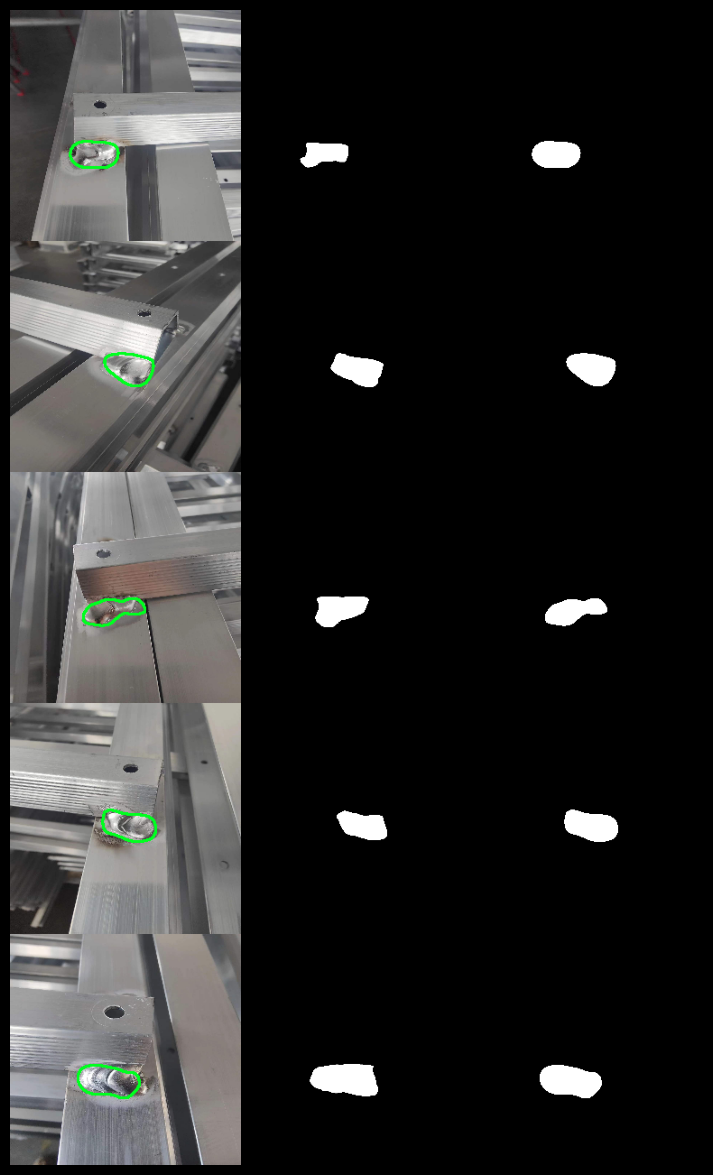

In [73]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as T

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Load model (ensure proper weight initialization)
model = UnetFPN()
model.load_state_dict(torch.load("/content/UnetFPN_100.pt", map_location=device))  # Load trained weights
model.to(device)
model.eval()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Ensures numerical stability
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()


dataset_path = '/content/welding-spots-100/welding_spots'
image_path = f'{dataset_path}/image'
mask_path = f'{dataset_path}/mask'

image_files = os.listdir(image_path)
image_size = 256  # Adjust as per your model input size

# Visualization grid
grids = []
for _ in range(5):
    choice = np.random.randint(0, len(image_files))
    imgx = cv2.imread(f"{image_path}/{image_files[choice]}")
    mskx = cv2.imread(f"{mask_path}/{image_files[choice].replace('jpg', 'png')}", cv2.IMREAD_GRAYSCALE)

    imgx = cv2.resize(imgx, (image_size, image_size))
    mskx = cv2.resize(mskx, (image_size, image_size))

    # Convert to tensor and normalize
    timgx = test_transforms(imgx).unsqueeze(0).to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        outputs = model(timgx)
        pred = torch.sigmoid(outputs).cpu().numpy()[0, 0, :, :]  # Apply sigmoid for probability output

    # Debugging Prediction Values
    print(f"Prediction Shape: {pred.shape}, Min: {pred.min()}, Max: {pred.max()}")

    # Compute threshold dynamically
    threshold = (pred.min() + pred.max()) / 2
    print(f"Threshold used: {threshold}")

    # Ensure valid thresholding
    pred_t = (pred >= threshold).astype("uint8") * 255

    # Extract contours properly
    contours_pred, _ = cv2.findContours(pred_t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    overlap_img = imgx.copy()
    cv2.drawContours(overlap_img, contours_pred, -1, (32, 255, 0), 2)

    # Display images
    grids.extend([overlap_img, mskx, pred_t])

# Show final image grid
def _imgrid(images, nrow=3, padding=10, pad_value=127):
    """Creates a grid of images."""
    ncol = len(images) // nrow
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in images]
    grid_img = np.concatenate([np.concatenate(images[i * nrow: (i + 1) * nrow], axis=1) for i in range(ncol)], axis=0)
    return grid_img

def _imshow(img, figsize=(9, 15)):
    """Displays an image using matplotlib."""
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
    plt.show()

    grids.extend([imgx, mskx, pred_t])
_imshow(_imgrid(grids, nrow=3, padding=10, pad_value=127), figsize=(9, 3*5))


In [76]:
def _imgrid(images, nrow=3, padding=10, pad_value=127):
    """Creates a grid of images."""
    ncol = len(images) // nrow

    # Ensure ncol is at least 1 to avoid an empty list
    ncol = max(1, ncol)

    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in images]
    grid_img = np.concatenate([np.concatenate(images[i * nrow: (i + 1) * nrow], axis=1) for i in range(ncol)], axis=0)
    return grid_img

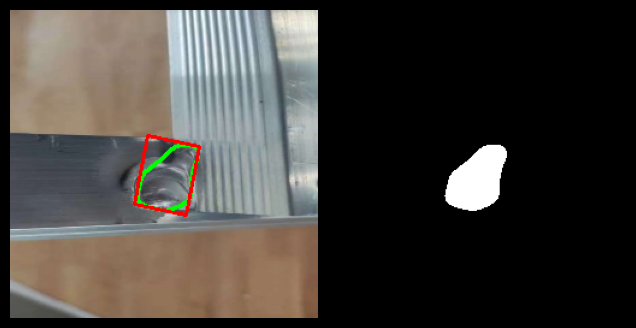

In [77]:
test_img = _imread('https://datasets-1301930378.cos.ap-beijing.myqcloud.com/samples/weldingspots/test.jpg')
imgx = cv2.resize(test_img, (image_size, image_size))

with torch.no_grad():
    timgx = test_transforms(imgx)
    inputs = timgx.unsqueeze(0).to(device)
    outputs = model(inputs)
    pred = outputs.detach().cpu().numpy()[0, 0, :, :]

    pred_t = np.copy(pred)
    pred_t[np.nonzero(pred_t < 0.3)] = 0.0
    pred_t[np.nonzero(pred_t >= 0.3)] = 255.
    pred_t = pred_t.astype("uint8")

contours_pred = cv2.findContours(pred_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
overlap_img = cv2.drawContours(imgx, contours_pred, 0, (0, 255, 0), 2)
object_contour = max(contours_pred, key=cv2.contourArea)
rect = cv2.minAreaRect(object_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)
cv2.drawContours(imgx, [box], 0, (0, 0, 255), 2)

_imshow(_imgrid([imgx, pred_t], padding=10, pad_value=127), figsize=(8, 4))

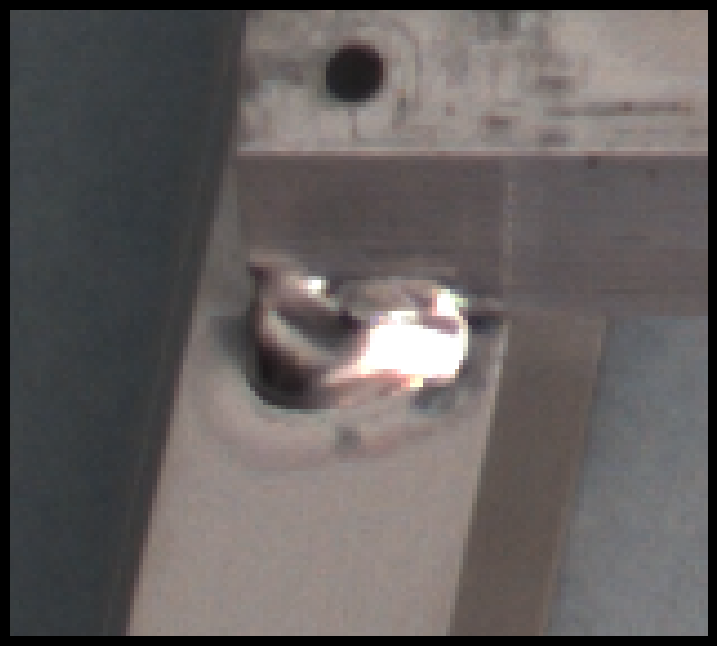

In [78]:
data_prefix = 'https://datasets-1301930378.cos.ap-beijing.myqcloud.com/samples/weldingspots'
test_samples = [_imread(f'{data_prefix}/weldingspot-%d.png' % i) for i in range(1, 9)]
_imshow(test_samples[0])

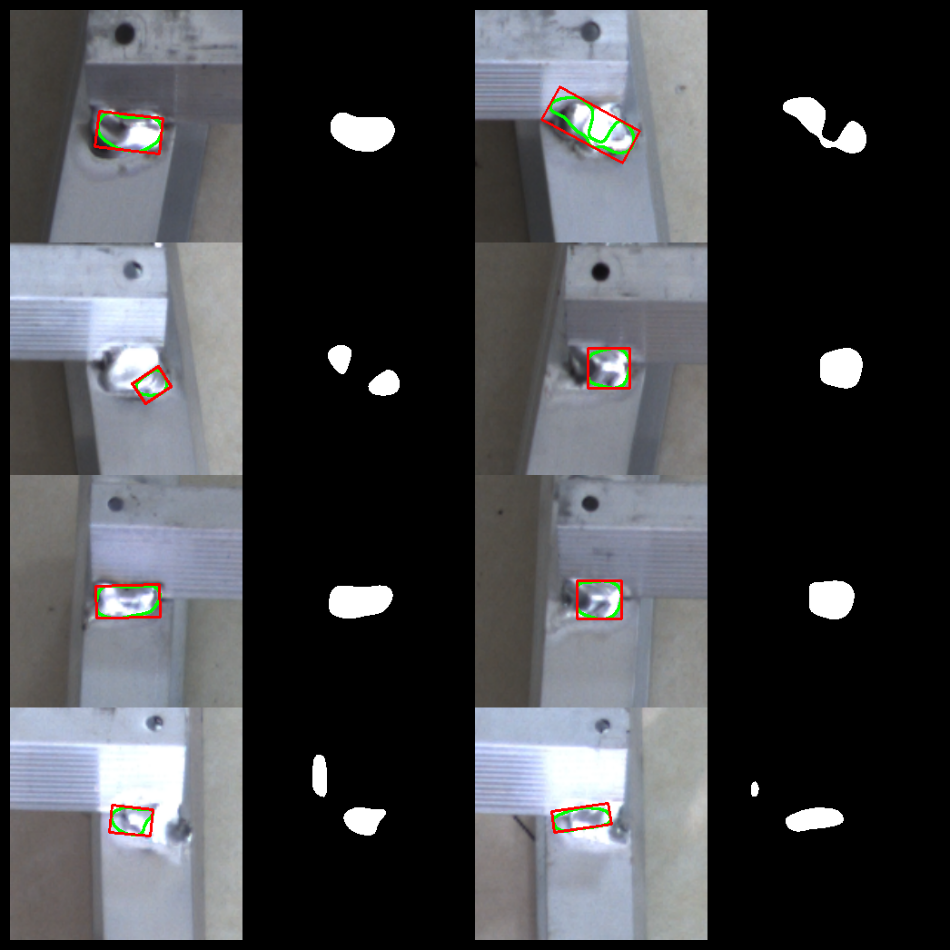

In [79]:
grid_images = []
for i in range(len(test_samples)):
    imgx = cv2.resize(test_samples[i], (image_size, image_size))
    with torch.no_grad():
        timgx = test_transforms(imgx)
        inputs = timgx.unsqueeze(0).to(device)
        outputs = model(inputs)
        pred = outputs.detach().cpu().numpy()[0, 0, :, :]

        pred_t = np.copy(pred)
        pred_t[np.nonzero(pred_t < 0.3)] = 0.0
        pred_t[np.nonzero(pred_t >= 0.3)] = 255.
        pred_t = pred_t.astype("uint8")

    contours_pred = cv2.findContours(pred_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    overlap_img = cv2.drawContours(imgx, contours_pred, 0, (0, 255, 0), 2)
    object_contour = max(contours_pred, key=cv2.contourArea)
    rect = cv2.minAreaRect(object_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(imgx, [box], 0, (0, 0, 255), 2)
    grid_images.extend([imgx, pred_t])

_imshow(_imgrid(grid_images, nrow=4, padding=10, pad_value=127), figsize=(12, 16))

(2048, 3072, 3)


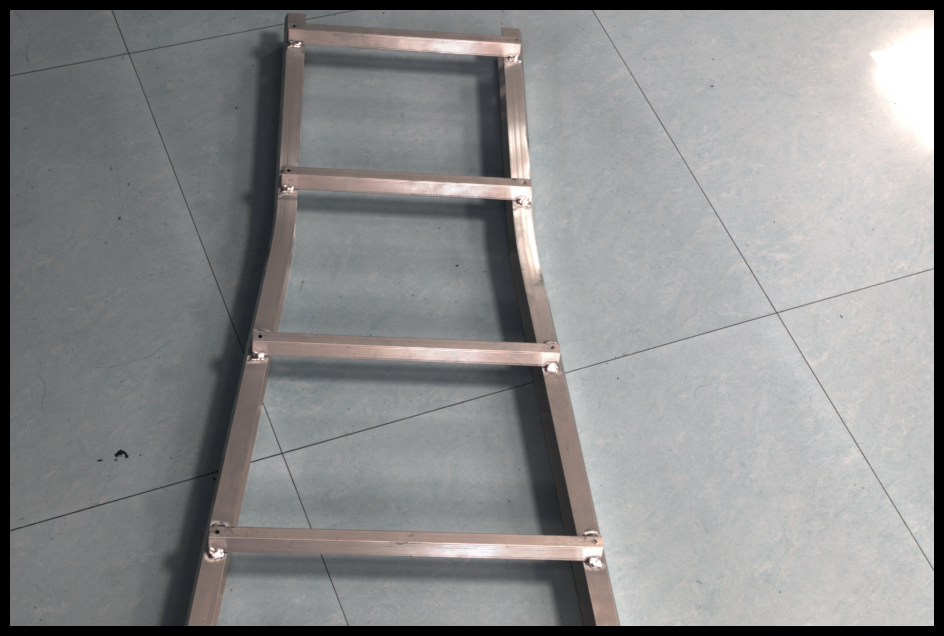

In [80]:
ladder = _imread(f'{data_prefix}/ladder.jpg')
print(ladder.shape)
_imshow(ladder, figsize=(12, 8))

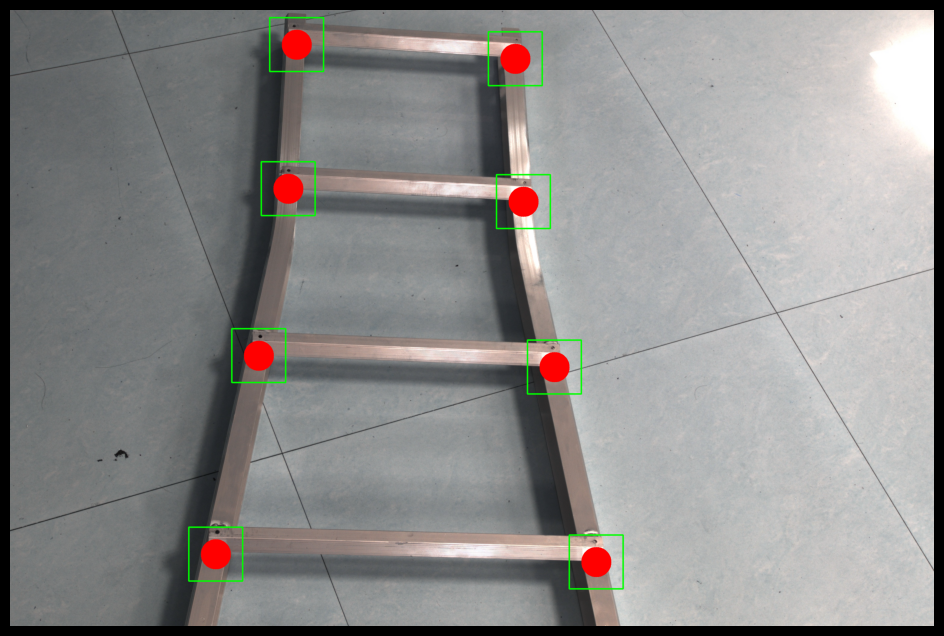

In [81]:
# TODO manually set the welding spot center point.
spot_points = [
    (684, 1809),
    (1949, 1835),
    (827, 1149),
    (1810, 1187),
    (925, 594),
    (1707, 637),
    (953, 115),
    (1680, 162),
]

box_edge_length = 180
box_squarts = []
offset = box_edge_length // 2
ladder_circle = ladder.copy()
for point in spot_points:
    x1, y1, x2, y2 = point[0] - offset, point[1] - offset, point[0] + offset, point[1] + offset
    box_squarts.append([x1, y1, x2, y2])
    cv2.circle(ladder_circle, point, radius=50, color=(255, 0, 0), thickness=-1)
    cv2.rectangle(ladder_circle, (x1, y1, box_edge_length, box_edge_length), color=(0, 255, 0), thickness=3)
_imshow(ladder_circle, figsize=(12, 8))

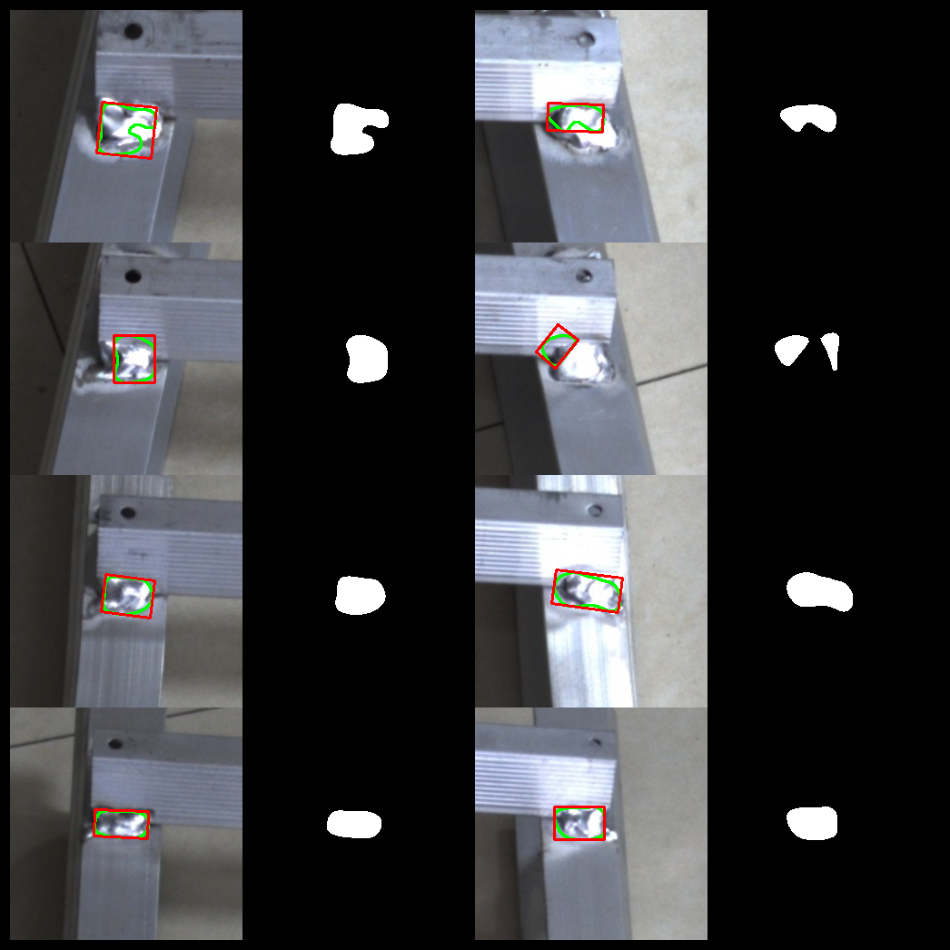

In [82]:
test_samples = [ladder[y1:y2, x1:x2] for x1, y1, x2, y2 in box_squarts]

grid_images = []
for i in range(len(test_samples)):
    imgx = cv2.resize(test_samples[i], (image_size, image_size))
    with torch.no_grad():
        timgx = test_transforms(imgx)
        inputs = timgx.unsqueeze(0).to(device)
        outputs = model(inputs)
        pred = outputs.detach().cpu().numpy()[0, 0, :, :]

        pred_t = np.copy(pred)
        pred_t[np.nonzero(pred_t < 0.3)] = 0.0
        pred_t[np.nonzero(pred_t >= 0.3)] = 255.
        pred_t = pred_t.astype("uint8")

    contours_pred = cv2.findContours(pred_t, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    overlap_img = cv2.drawContours(imgx, contours_pred, 0, (0, 255, 0), 2)
    object_contour = max(contours_pred, key=cv2.contourArea)
    rect = cv2.minAreaRect(object_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)
    cv2.drawContours(imgx, [box], 0, (0, 0, 255), 2)
    grid_images.extend([imgx, pred_t])

_imshow(_imgrid(grid_images, nrow=4, padding=10, pad_value=127), figsize=(12, 16))